In [2]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [2]:
class Word:
    def __init__(self, word: str):
        self._word = word
    def __repr__(self):
        return repr(self._word)
    def H(self):
        return Word(self._word[::-1])
    def __hash__(self):
        return hash(self._word)
    def __eq__(self, other):
        if not isinstance(other, Word):
            return False
        return self._word == other._word

class TraceOp:
    def __init__(self, word: Word):
        self._word = word
        self._expval = cp.Variable(1, str(self._word), complex=True)
    def __hash__(self):
        return hash(self._word)
    def ev(self):
        return self._expval
    def conjev(self):
        return cp.conj(self._expval)
    def __eq__(self, other):
        if not isinstance(other, TraceOp):
            return False
        return self._word == other._word

TOcache = dict()

def trace_op(word: Word|str):
    if isinstance(word, str):
        word = Word(word)
    if word not in TOcache:
        TOcache[word] = TraceOp(word)
    return TOcache[word]

def commutator(word1: str, word2: str):
    expression = []
    for i in range(len(word1)):
        for j in range(len(word2)):
            # I took the following line from Hartnoll/Xi Yin's code
            word = word1[:i] + word2[j+1:] + word2[:j] + word1[i+1:]
            if word1[i] == 'x' and word2[j] == 'p':
                expression.append('+' + word)
            elif word1[i] == 'p' and word2[j] == 'x':
                expression.append('-' + word)
    return expression

In [3]:
def normalization():
    return [trace_op('').ev() == 1]

def moment_matrix(op_basis, L):
    ops = [op
           for i in range(L//2 + 1)
           for op in op_basis[i]]
    n = len(ops)
    M = cp.bmat([[trace_op(ops[i][::-1] + ops[j]).ev() for j in range(n)] for i in range(n)])
    return [M >> 0]

def symmetry_constraint(G: list, word: str):
    return [sum(coeff * trace_op(w + word).ev() for coeff, w in G) == 0]

def schwinger_dyson(hamil: list, word: str):
    expression = 0
    for coeff, w in hamil:
        terms = commutator(w, word)
        for term in terms:
            if term[0] == '+':
                expression = expression + coeff * trace_op(term[1:]).ev()
            else:
                expression = expression - coeff * trace_op(term[1:]).ev()
    return [expression == 0]

def ground_state_constraints(hamil: list, word: str):
    expression = 0
    for coeff, w in hamil:
        terms = commutator(w, word)
        for term in terms:
            if term[0] == '+':
                expression = expression + coeff * trace_op(word[::-1] + term[1:]).ev()
            else:
                expression = expression - coeff * trace_op(word[::-1] + term[1:]).ev()
    return [cp.real(expression) >= 0]

def reality(word: str):
    return [trace_op(word[::-1]).ev() == trace_op(word).conjev()]

def trace_cyclicity(word: str):
    word1 = word
    word2 = word[1:] + word[0]
    expression = trace_op(word2).ev()
    for i in range(1, len(word1)):
        if word[0] == 'x' and word[i] == 'p':
            expression = expression + 1j * trace_op(word[1:i]).ev() * trace_op(word[i+1:]).ev()
        elif word[1] == 'p' and word[i] == 'x':
            expression = expression - 1j * trace_op(word[1:i]).ev() * trace_op(word[i+1:]).ev()
    return [trace_op(word1) == expression]

In [4]:
def solve_for(L):
    print(f'Solving for L={L}:')
    # Setup
    G = [(1j, 'xp'), (-1j, 'px'), (1, '')]
    op_basis = [[] for _ in range(L + 1)]
    basis = ['x','p']
    for l,v in enumerate(op_basis):
        v.extend(''.join(s) for s in product(basis,repeat=l))
    # Create constraints
    constraints = []
    constraints.extend(normalization())
    constraints.extend(moment_matrix(op_basis, L))
    for i in range(L - 1):
        for word in op_basis[i]:
            constraints.extend(symmetry_constraint(G, word))
    for i in range(L + 1):
        for word in op_basis[i]:
            constraints.extend(reality(word))
    # Start solving
    gs = np.linspace(0,4,num=10)
    mins = []
    xxs = []
    for g in gs:
        hamil = [(1, 'pp'), (1, 'xx'), (g, 'xxxx')]
        hamil_constraints = []
        for i in range(L - 1):
            for word in op_basis[i]:
                hamil_constraints.extend(schwinger_dyson(hamil, word))
        for i in range(L//2):
            for word in op_basis[i]:
                hamil_constraints.extend(ground_state_constraints(hamil, word))
        total_constraints = constraints + hamil_constraints
        minobj = cp.Minimize(cp.real(sum(coeff * trace_op(w).ev() for coeff, w in hamil)))
        minprob = cp.Problem(minobj, total_constraints)
        print(f'\tSolving for g={g}:')
        mins.append(minprob.solve(solver=cp.MOSEK, accept_unknown = True))
        xxs.append(np.real(trace_op('xx').ev().value)[0])
        print(f'\t\tE_min = {mins[-1]}')
        print(f'\t\t<X^2>_min = {xxs[-1]}')
    return gs, mins, xxs

In [5]:
gs6, mins6, xxs6 = solve_for(6)
gs8, mins8, xxs8 = solve_for(8)
gs10, mins10, xxs10 = solve_for(10)

Solving for L=6:
	Solving for g=0.0:
		E_min = 1.0000000155573616
		<X^2>_min = 0.5000000077786811
	Solving for g=0.4444444444444444:
		E_min = 1.0935104035607321
		<X^2>_min = 0.42585406737355436
	Solving for g=0.8888888888888888:
		E_min = 1.1661060039762885
		<X^2>_min = 0.3852070418409445
	Solving for g=1.3333333333333333:
		E_min = 1.2272087878726348
		<X^2>_min = 0.35770238881171956
	Solving for g=1.7777777777777777:
		E_min = 1.2807399326020519
		<X^2>_min = 0.33718560706956635
	Solving for g=2.2222222222222223:
		E_min = 1.3287962153757862
		<X^2>_min = 0.32097710397082574
	Solving for g=2.6666666666666665:
		E_min = 1.372657793368402
		<X^2>_min = 0.30767450131032353
	Solving for g=3.1111111111111107:
		E_min = 1.413175081788598
		<X^2>_min = 0.29645497327585174
	Solving for g=3.5555555555555554:
		E_min = 1.4509471275629273
		<X^2>_min = 0.28679613026797524
	Solving for g=4.0:
		E_min = 1.486414713528243
		<X^2>_min = 0.27834655051538915
Solving for L=8:
	Solving for g=0.0:
	

/home/mainak/mtp/my-work/.venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:164: UserWarning: Constraint #2 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


		E_min = 1.0000000113079648
		<X^2>_min = 0.5000000056539828
	Solving for g=0.4444444444444444:
		E_min = 1.0935104035605525
		<X^2>_min = 0.4258540616720511
	Solving for g=0.8888888888888888:
		E_min = 1.1661060028996912
		<X^2>_min = 0.38520703715022786
	Solving for g=1.3333333333333333:
		E_min = 1.2272088456030699
		<X^2>_min = 0.35770236883056017
	Solving for g=1.7777777777777777:
		E_min = 1.2807399323339734
		<X^2>_min = 0.337185604668992
	Solving for g=2.2222222222222223:
		E_min = 1.3287962348629496
		<X^2>_min = 0.32097709809483527
	Solving for g=2.6666666666666665:
		E_min = 1.372657808900568
		<X^2>_min = 0.30767449954905857
	Solving for g=3.1111111111111107:
		E_min = 1.4131750855624894
		<X^2>_min = 0.2964549701292612
	Solving for g=3.5555555555555554:
		E_min = 1.45094713139717
		<X^2>_min = 0.2867961246535549
	Solving for g=4.0:
		E_min = 1.4864147323765189
		<X^2>_min = 0.2783465464646796


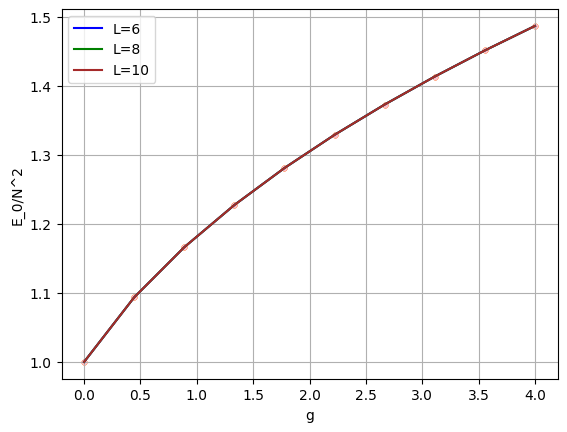

In [6]:
plt.plot(gs6, mins6, c='blue', label='L=6')
plt.scatter(gs6, mins6, c='red', s=10)
plt.plot(gs8, mins8, c='green', label='L=8')
plt.scatter(gs8, mins8, c='orange', s=10)
plt.plot(gs10, mins10, c='brown', label='L=10')
plt.scatter(gs10, mins10, c='pink', s=10)
plt.xlabel('g')
plt.ylabel('E_0/N^2')
plt.legend()
plt.grid()
# plt.xlim(1.7,1.8)
# plt.ylim(1.27,1.285)
plt.show()

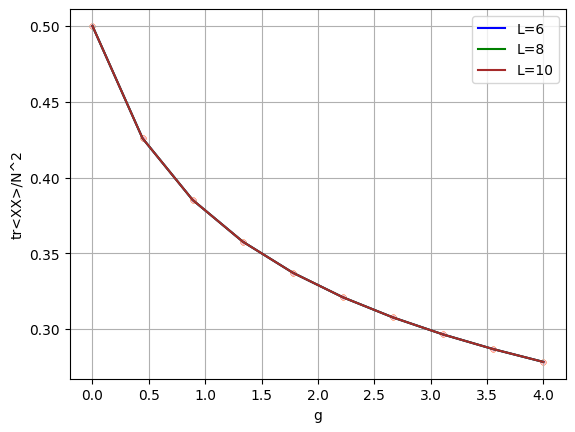

In [ ]:
plt.plot(gs6, xxs6, c='blue', label='L=6')
plt.scatter(gs6, xxs6, c='red', s=10)
plt.plot(gs8, xxs8, c='green', label='L=8')
plt.scatter(gs8, xxs8, c='orange', s=10)
plt.plot(gs10, xxs10, c='brown', label='L=10')
plt.scatter(gs10, xxs10, c='pink', s=10)
plt.xlabel('g')
plt.ylabel('tr<XX>/N^2')
plt.legend()
plt.grid()
plt.show()

<h2>Line search:</h2>

What we will do, is maintain $a$, and then at each step, we use $x+a$ and try to find $x$. Then we update $a_{\text{new}} = a + \text{step} \cdot x$ where $\text{step}$ is some value determining how far we go. If our step fails, we need to choose a smaller step. We have a max step length. And finally, we terminate if $||x||_2 < \delta$ for some cutoff $\delta$.

Add a $||x||_2 < \delta$ constraint (SOCP?).

In [ ]:
class LinConstraints:
    def __init__(self, M, b):
        self._M = M
        self._b = b
    def __call__(self, a):
        return self._M @ a
    def grad(self, a):
        return self._M
    def rhs(self):
        return self._b

class QuadConstraint:
    def __init__(self, M, N):
        self._M = M
        self._N = N
    def __call__(self, a):
        return self._N.T @ a + a.T @ self._M @ a
    def grad(self, a):
        return self._N + 2 * self._M @ a
    def hess(self):
        return self._M
    def rhs(self):
        return 0

class Solver:
    def __init__(self, constraints: list[LinConstraints|QuadConstraint], objective,
                 v, B, initial_point, max_quad_tol, max_trust_radius):
        self._C = constraints
        self._v = v # This is the array of variables
        self._B = B # This is the moment matrix
        self._obj = objective # This is the objective to minimise
        self._a = initial_point # This is the initial point
        self._res = 0 # TODO: This must be a function of the initial point! This is the final answer.
        self._max_quad_tol = max_quad_tol # Maximum violation of quadratic constraints
        self._max_trust_radius = max_trust_radius # Maximum value of trust region radius

    def step(self):
        """
        Take in a, and return a new point a_new.
        The objective is linear, so no problems in minimizing it directly.
        """
        # Linear and quadratic constraints
        constraints = [c(self._a) + c.grad(self._a).T @ self._v == c.rhs() for c in constraints]
        # Positive semidefinite constraint
        constraints.append(self._B + self._B.value >> 0)
        # Trust region radius
        constraints.append(cp.norm2(self._v) <= self._max_trust_radius)
        # Now solve
        prob = cp.Problem(cp.Minimize(self._obj), constraints)
        prob.solve()
        return self._a + self._v.value
    
    def accept_step(self):
        """
        This is always called just after step(), so the value of v is preserved.
        The strategy is:
        1.  Reject the step if the 2-norm of the deviation from the quadratic constraints
            exceeds maximum tolerance and decrease trust region radius.
        2.  Reject the step if the value of self._obj
        """

    def solve(self):
        """
        Solve the problem by taking steps.
        """

In [ ]:
class LineSearch:
    def __init__(self, start):
        pass